# ML Pipeline for Accelerometer Data

First just dabble with accelerometer data.

We will use it for seizure detection, and then seizure prediction. 

Using autoML approach plus feature set (either TSFresh or pycatch22)

This notebook is for getting things to work.

In [2]:
# Import Packages
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io 
import re
from scipy.fft import fft, fftfreq
from pathlib import Path

import RandFuncs
import pycatch22
import autosklearn.classification
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn import metrics
import pickle

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [122]:
# Get all parquet files in the directory and subdirectory. 
# https://stackoverflow.com/questions/2909975/python-list-directory-subdirectory-and-files

# root is the folder/directory of the patient.  
root = Path(os.getcwd()+ '/Ignore/Output/1110/')
files = [os.path.join(path, name) for path, subdirs, files in os.walk(root) for name in files if name[-8:]==".parquet"]
# Sort Path by Ascending Order
files.sort(reverse=False)
# Print a few of the file paths as a check
print(files[0:5])

['/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/1110/060/UTC-2020_05_25-23_20_00.parquet', '/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/1110/060/UTC-2020_05_25-23_30_00.parquet', '/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/1110/060/UTC-2020_05_25-23_40_00.parquet', '/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/1110/060/UTC-2020_05_25-23_50_00.parquet', '/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/1110/060/UTC-2020_05_26-00_00_00.parquet']


In [123]:
# First load one of the parquet files of the patient
file_path = files[0]
data = pd.read_parquet(file_path,engine='pyarrow')
# Change first column to datetime format
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'], utc=True, unit='s')

data

,utc_timestamp,acc_x,acc_y,acc_z,acc_mag,bvp,eda,hr,temp
0,2020-05-25 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-25 23:20:00.007812864+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-25 23:20:00.015624960+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-25 23:20:00.023437824+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-25 23:20:00.031249920+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
76795,2020-05-25 23:29:59.960937472+00:00,-0.997473,62.996995,6.002834,62.291661,-11.010712,0.0,123.394669,NaN
76796,2020-05-25 23:29:59.968750336+00:00,-0.997473,62.996995,6.002834,62.291661,-24.282581,0.0,123.421586,NaN
76797,2020-05-25 23:29:59.976562432+00:00,-0.997473,62.996995,6.002834,62.291661,-32.718963,0.0,123.448503,NaN
76798,2020-05-25 23:29:59.984375296+00:00,-0.997473,62.996995,6.002834,62.291661,-36.834271,0.0,123.475420,NaN


In [21]:
# As the patient "only has 32GB of data", we could probably load it all into memory.

# Iterate through all the files and turn it into a single dataframe
# Load all the DataFrames into an Empty List and Concat at end for efficiency.  
# Initialise an empty List
li = []
# Load the labels
labels = pd.read_csv('/Users/pokhims/Documents/Coding/PK_EForecasting/Ignore/Output/train_labels.csv')

for file_path in files:

    # First load one of the parquet files of the patient
    data = pd.read_parquet(file_path,engine='pyarrow')
    # Change first column to datetime format
    data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'], utc=True, unit='s')

    # Add in the training labels. 
    # No clue which ones are the updated ones, so just use the old ones. 
    # Get rid of the os.cwd() component of the path to match it with the labels csv
    path = file_path.replace(os.getcwd()+'/Ignore/Output/', '')
    label = labels[['label']].loc[labels['filepath'] == str(path)].values[0]

    data['label'] = np.repeat(label, repeats = data.shape[0])

    # Perform NAN treatment later

    # Append to list
    li.append(data)

# Convert to df
data = pd.concat(li,axis=0,ignore_index=True)
# Sort by the time
data = data.sort_values(by="utc_timestamp")

# Return data
data

,utc_timestamp,acc_x,acc_y,acc_z,acc_mag,bvp,eda,hr,temp,label
0,2020-05-25 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-05-25 23:20:00.007812864+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2020-05-25 23:20:00.015624960+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2020-05-25 23:20:00.023437824+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2020-05-25 23:20:00.031249920+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
19967995,2020-08-01 16:49:59.960937472+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967996,2020-08-01 16:49:59.968750336+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967997,2020-08-01 16:49:59.976562432+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967998,2020-08-01 16:49:59.984375296+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [22]:
# Let's just keep as much as possible and the Nans for now.

# # Drop temp for now as it's all nans for this data file
# data = data.drop(columns=['temp'])

# # Drop EDA - I have 0 belief that this will be useful
# data = data.drop(columns=['eda'])

# # If acc_mag is a Nan drop it. 
# data = data.dropna(subset=['acc_mag'])

In [23]:
data

,utc_timestamp,acc_x,acc_y,acc_z,acc_mag,bvp,eda,hr,temp,label
0,2020-05-25 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-05-25 23:20:00.007812864+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2020-05-25 23:20:00.015624960+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2020-05-25 23:20:00.023437824+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2020-05-25 23:20:00.031249920+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
19967995,2020-08-01 16:49:59.960937472+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967996,2020-08-01 16:49:59.968750336+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967997,2020-08-01 16:49:59.976562432+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
19967998,2020-08-01 16:49:59.984375296+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [24]:
# Want to transform from Cartesian to Polar Coordinates

# First get the magnitude of the acceleration
# For some reason acc_mag is different from the calcualted magnitude.  By roughly 1.  My guess is that their mag was calculated after a normalisation step which removed the mean of 1g. 
# print(data["acc_mag"] - np.sqrt(data["acc_x"]**2 + data["acc_y"]**2 + data["acc_z"]**2))
# Therefore, replace it with a calculated one
data["acc_mag"] = np.sqrt(data["acc_x"]**2 + data["acc_y"]**2 + data["acc_z"]**2)

# Then get theta
data["acc_theta"] = np.arctan2(data["acc_y"],data["acc_x"])

# Then get phi
data["acc_phi"] = np.arccos(data["acc_z"]/data["acc_mag"])

In [25]:
print(np.min(data["acc_z"]/data["acc_mag"]))
print(np.max(data["acc_z"]/data["acc_mag"]))

-0.9999959374196743
0.9999994077848491


In [26]:
data

# Might need to consider z-score normalisation.  But only for selected columns. 
# Catch22 normalises for most of the features. Not sure if autosklearn does it automatically.
# Normalisation probably needs to occur after a co-ordinate transform?

,utc_timestamp,acc_x,acc_y,acc_z,acc_mag,bvp,eda,hr,temp,label,acc_theta,acc_phi
0,2020-05-25 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2020-05-25 23:20:00.007812864+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2020-05-25 23:20:00.015624960+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,2020-05-25 23:20:00.023437824+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,2020-05-25 23:20:00.031249920+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19967995,2020-08-01 16:49:59.960937472+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
19967996,2020-08-01 16:49:59.968750336+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
19967997,2020-08-01 16:49:59.976562432+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
19967998,2020-08-01 16:49:59.984375296+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [27]:
# Count number of rows with Nans
print("Rows with nans = ",np.isnan(data).any(axis=1).sum())
print(np.isnan(data).any(axis=1).sum()/data.shape[0])

Rows with nans =  19098280
0.9564443108974359


In [28]:
# plt.figure(figsize=(20,10))
# plt.plot(data['utc_timestamp'],data['acc_x'])
# plt.plot(data['utc_timestamp'],data['acc_y'])
# plt.plot(data['utc_timestamp'],data['acc_z'])
# plt.plot(data['utc_timestamp'],data['acc_mag'])
# plt.grid()

In [29]:
# plt.figure(figsize=(20,10))
# plt.plot(data['utc_timestamp'],data['acc_mag'])
# plt.plot(data['utc_timestamp'],data['acc_theta'])
# plt.plot(data['utc_timestamp'],data['acc_phi'])
# plt.grid()

In [30]:
window_size = 10
f_s = 128

# Specify columns to use
cols = ["acc_mag","acc_theta","acc_phi",]
# Extract relevant columns
#data = data[cols + ["utc_timestamp"]]   

# Figure out how many elements goes into each window.
number = int(window_size*f_s)

# Length of the data_file
file_len = data.shape[0]

# Initialize list to save data per window
li = []

# Loop through the data file, creating windows of data and running Catch22.
for k in np.arange(np.floor(file_len/number)):

    # Create or specify the window of data.
    # Just in case, maybe the 10min data file is completely empty or something, we need to do a try-except to move on.
    try:
        # Specify window
        window = data.iloc[int(k*number):int((k+1)*number),:]
    except:
        continue

    # Basic checks which might throw errors.  If they do, we just skip that window.
    # If array is empty skip it.
    if window.size==0:
        continue
    # If array has Nans skip it.  - This is not ideal, but just want to get something going quickly. 
    # elif np.isnan(window).any().any():
    #     continue

    # For each column of dataframe apply catch22
    li1 = []
    for i in cols:
        features = pycatch22.catch22_all(window[i], catch24=True, )
        li1.append(features["values"])  

    # Flatten the list of lists
    li1 = [item for sublist in li1 for item in sublist]
    # Record the utc_timestamp of the start of each window
    li1.append(window['utc_timestamp'].iloc[0])    
    # Record the label of the start of each window
    li1.append(window['label'].iloc[0])

    # # Record the utc_timestamp of the start of each window
    # li1.append(window['utc_timestamp'].iloc[0])
    # # Turn this list into an array 
    # li1 = np.array(li1)
    # # Flatten this first list
    # li1 = li1.flatten()

    # Add to list saving data per window
    li.append(li1)

# Turn the list into the appropriate pd.DataFrame
# Create column names
feature_names = np.loadtxt("Catch22_Featurenames",dtype=str)
col_names = [i + "_" + j for i in cols for j in feature_names]
col_names = col_names + ["utc_timestamp"] + ["label"]

# Create dataframe
df = pd.DataFrame(li,columns=col_names)

KeyboardInterrupt: 

In [ ]:
df

,acc_mag_DN_HistogramMode_5,acc_mag_DN_HistogramMode_10,acc_mag_CO_f1ecac,acc_mag_CO_FirstMin_ac,acc_mag_CO_HistogramAMI_even_2_5,acc_mag_CO_trev_1_num,acc_mag_MD_hrv_classic_pnn40,acc_mag_SB_BinaryStats_mean_longstretch1,acc_mag_SB_TransitionMatrix_3ac_sumdiagcov,acc_mag_PD_PeriodicityWang_th0_01,...,acc_phi_SB_BinaryStats_diff_longstretch0,acc_phi_SB_MotifThree_quantile_hh,acc_phi_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,acc_phi_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,acc_phi_SP_Summaries_welch_rect_centroid,acc_phi_FC_LocalSimple_mean3_stderr,acc_phi_DN_Mean,acc_phi_DN_Spread_Std,utc_timestamp,label
0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:00+00:00,0
1,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:10+00:00,0
2,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:20+00:00,0
3,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:30+00:00,0
4,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:40+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15595,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:10+00:00,0
15596,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:20+00:00,0
15597,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:30+00:00,0
15598,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:40+00:00,0


In [ ]:
# df.to_pickle("Patient_1110.pkl")
# Is 9MB compared to 380mb for the raw data.  So that's a 97% reduction in size.

In [ ]:
df['label'].mean()


0.0

In [ ]:
# Add Quality Features
df["acc_quality"] = RandFuncs.acc_quality_adj(data, f_s)
#df["bvp_quality"] = RandFuncs.bvp_quality_adj(data, f_s)
#df["eda_quality"] = RandFuncs.eda_quality_adj(data, f_s)

# There is a possibility that these need to be performed on a larger window? 
# This is just giving out NaNs.... There is a bug somewhere.  

short chunk


ValueError: cannot reshape array of size 38514 into shape (15)

In [ ]:
df

,acc_mag_DN_HistogramMode_5,acc_mag_DN_HistogramMode_10,acc_mag_CO_f1ecac,acc_mag_CO_FirstMin_ac,acc_mag_CO_HistogramAMI_even_2_5,acc_mag_CO_trev_1_num,acc_mag_MD_hrv_classic_pnn40,acc_mag_SB_BinaryStats_mean_longstretch1,acc_mag_SB_TransitionMatrix_3ac_sumdiagcov,acc_mag_PD_PeriodicityWang_th0_01,...,acc_phi_SP_Summaries_welch_rect_area_5_1,acc_phi_SB_BinaryStats_diff_longstretch0,acc_phi_SB_MotifThree_quantile_hh,acc_phi_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,acc_phi_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,acc_phi_SP_Summaries_welch_rect_centroid,acc_phi_FC_LocalSimple_mean3_stderr,acc_phi_DN_Mean,acc_phi_DN_Spread_Std,utc_timestamp
0,0.572093,0.016976,3.644704,9,0.060949,-0.047277,0.457389,18.0,0.018476,43,...,0.911547,6.0,1.013508,0.229167,0.125000,0.297592,0.696617,1.471254,0.005907,2020-05-25 23:29:42+00:00
1,0.993162,0.208790,3.552545,9,0.019007,-0.064214,0.478499,18.0,0.011553,23,...,0.903904,9.0,0.995992,0.208333,0.125000,0.309864,0.701677,1.471049,0.005915,2020-05-25 23:29:52+00:00
2,0.965658,0.183288,3.270531,7,0.089803,-0.205094,0.417514,16.0,0.037096,22,...,0.901257,13.0,1.115961,0.291667,0.145833,0.294524,0.679431,1.472015,0.006263,2020-05-25 23:30:02+00:00
3,-0.274656,0.453445,2.866077,6,0.102263,-0.192702,0.420641,22.0,0.014118,18,...,0.921022,10.0,1.032467,0.187500,0.125000,0.208621,0.612867,1.470081,0.006447,2020-05-25 23:30:12+00:00
4,0.412421,-0.264990,5.210617,16,0.177042,-0.016347,0.290852,34.0,0.006655,29,...,0.992576,18.0,1.482908,0.125000,0.333333,0.009204,0.115930,1.595345,0.327130,2020-05-25 23:30:22+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15395,-0.700592,-0.340732,6.650192,18,0.500885,-0.000820,0.763096,39.0,0.006221,43,...,0.998260,26.0,1.256045,0.125000,0.875000,0.006136,0.066724,2.147000,0.357710,2020-08-01 16:40:11.437499904+00:00
15396,-0.325017,0.248460,5.300336,13,0.272229,0.021856,0.802971,36.0,0.000975,71,...,0.998531,33.0,1.182322,0.125000,0.750000,0.003068,0.080454,2.186284,0.219101,2020-08-01 16:40:21.437499904+00:00
15397,-0.107770,-0.479224,8.292483,25,0.537915,0.000933,0.794371,42.0,0.003158,63,...,0.996084,29.0,1.271838,0.187500,0.145833,0.006136,0.132335,2.309776,0.150432,2020-08-01 16:40:31.437499904+00:00
15398,0.475277,-0.136008,5.950824,23,0.297600,-0.037166,0.698984,52.0,0.004030,66,...,0.996511,29.0,1.245089,0.125000,0.750000,0.003068,0.104860,2.125000,0.361957,2020-08-01 16:40:41.437499904+00:00


In [ ]:
print(np.sum(np.isnan(df["acc_quality"])))
print(df.shape)

KeyError: 'acc_quality'

In [ ]:
# The current files are all 0s so just to give it some 1s
df['label'] = np.repeat(np.random.randint(0,1),df.shape[0])

# Model Training

In [233]:
# Import the whole dataset from pkl file
df = pd.read_pickle(os.getcwd()+ "/Ignore/Output/Patient_1876.pkl")

In [4]:
df

,acc_mag_DN_HistogramMode_5,acc_mag_DN_HistogramMode_10,acc_mag_CO_f1ecac,acc_mag_CO_FirstMin_ac,acc_mag_CO_HistogramAMI_even_2_5,acc_mag_CO_trev_1_num,acc_mag_MD_hrv_classic_pnn40,acc_mag_SB_BinaryStats_mean_longstretch1,acc_mag_SB_TransitionMatrix_3ac_sumdiagcov,acc_mag_PD_PeriodicityWang_th0_01,...,hr_SB_BinaryStats_diff_longstretch0,hr_SB_MotifThree_quantile_hh,hr_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,hr_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,hr_SP_Summaries_welch_rect_centroid,hr_FC_LocalSimple_mean3_stderr,hr_DN_Mean,hr_DN_Spread_Std,utc_timestamp,label
0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-19 20:20:00+00:00,0
1,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-19 20:20:10+00:00,0
2,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-19 20:20:20+00:00,0
3,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-19 20:20:30+00:00,0
4,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-19 20:20:40+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157575,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 20:59:10+00:00,0
1157576,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 20:59:20+00:00,0
1157577,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 20:59:30+00:00,0
1157578,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 20:59:40+00:00,0


In [4]:
# sklaern GBM

# Split the dataset into training and testing sets
# Just do it across a time or do cross-validation when doing this seriously.
# training_data, testing_data, training_target, testing_target = train_test_split(df.drop('label', axis=1),
#                                                                                 df['label'], 
#                                                                                 train_size=0.75, 
#                                                                                 test_size=0.25,
#                                                                                 random_state=42)

# Specify Columns to Use as Input (in addition to the time-stamp)
cols = ["acc_mag","acc_theta","acc_phi",]

feature_names = np.loadtxt("Catch22_Featurenames",dtype=str)
col_names = [i + "_" + j for i in cols for j in feature_names]
col_names = col_names + ['time_of_day'] # Add the quality measurements later.

# Get time-of-day from timestamp
df['time_of_day'] = df['utc_timestamp'][0].hour + df['utc_timestamp'][0].minute/60 

# Perform train-test split. Just Split it across time 3:1
# And need to drop time-stamp. As datetime64 is unsupported 
training_data = df[col_names].iloc[0:int(df.shape[0]*0.75),:]
testing_data = df[col_names].iloc[int(df.shape[0]*0.75):,:]
training_target = df['label'].iloc[0:int(df.shape[0]*0.75)]
testing_target = df['label'].iloc[int(df.shape[0]*0.75):]

# # Give it some Nans just to see how autosklearn deals with it
# training_data.iloc[0:10,0] = np.nan 
# testing_data.iloc[0:10,0] = np.nan

# training_data["Nans"] = np.repeat(np.nan,training_data.shape[0])
# testing_data["Nans"] = np.repeat(np.nan,testing_data.shape[0])

# Need to adjust the metric
metric = autosklearn.metrics.roc_auc

# Initialize the auto-sklearn classifier
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 180,
                                                           per_run_time_limit = 30,
                                                           n_jobs = -1,
                                                           memory_limit = 102400000, # This needs to be set or else you may error out. 
                                                           metric = metric)  # Metric needs to be set to not accuracy due to imbalanced dataset

# Fit the classifier on the training data
automl.fit(training_data, training_target)

# Score the classifier on the testing data
print("Accuracy: ", automl.score(testing_data, testing_target))

# Save the model
dump(automl, 'Fast_automl_acc.joblib')

[WARNING] [2023-02-19 01:12:15,827:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:12:45,412:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:12:47,114:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:12:47,650:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:12:48,170:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:13:17,237:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:13:18,337:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:13:20,052:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:13:49,994:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-02-19 01:13:

['Fast_automl_acc.joblib']

In [5]:
print("Accuracy: ", automl.score(testing_data, testing_target))
print(metrics.roc_curve(testing_target,automl.predict(testing_data)))
print(metrics.roc_auc_score(testing_target,automl.predict(testing_data)))

Accuracy:  0.5
(array([0., 1.]), array([0., 1.]), array([1, 0]))
0.5


In [13]:
# Print out all the ways to inspet the results
print('Basic Statistics')
print(automl.sprint_statistics())
#print('Performance over Time')
#print(automl.performance_over_time_)
print('Evaluated Models')
print(automl.show_models())
print('Leaderboard')
print(automl.leaderboard())
print('CV Results')
print(automl.cv_results_)

Basic Statistics
auto-sklearn results:
  Dataset name: 245293ca-af96-11ed-942e-123e0c4dfe5e
  Metric: roc_auc
  Number of target algorithm runs: 40
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 39
  Number of target algorithms that exceeded the memory limit: 0

Evaluated Models


RuntimeError: No model found. Try increasing 'time_left_for_this_task'.

In [76]:
pd.read_pickle("Patient_1110.pkl")

,acc_mag_DN_HistogramMode_5,acc_mag_DN_HistogramMode_10,acc_mag_CO_f1ecac,acc_mag_CO_FirstMin_ac,acc_mag_CO_HistogramAMI_even_2_5,acc_mag_CO_trev_1_num,acc_mag_MD_hrv_classic_pnn40,acc_mag_SB_BinaryStats_mean_longstretch1,acc_mag_SB_TransitionMatrix_3ac_sumdiagcov,acc_mag_PD_PeriodicityWang_th0_01,...,acc_phi_SB_BinaryStats_diff_longstretch0,acc_phi_SB_MotifThree_quantile_hh,acc_phi_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,acc_phi_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,acc_phi_SP_Summaries_welch_rect_centroid,acc_phi_FC_LocalSimple_mean3_stderr,acc_phi_DN_Mean,acc_phi_DN_Spread_Std,utc_timestamp,label
0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:00+00:00,0
1,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:10+00:00,0
2,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:20+00:00,0
3,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:30+00:00,0
4,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-25 23:20:40+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15595,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:10+00:00,0
15596,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:20+00:00,0
15597,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:30+00:00,0
15598,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01 16:49:40+00:00,0


In [2]:
clf = load('Fast_automl_acc.joblib') 

In [90]:
metrics.roc_curve(testing_target,automl.predict(testing_data))

/Users/pokhims/neuro/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


(array([0., 1.]), array([nan, nan]), array([1, 0]))

# Model Training (but not Auto-sklearn but GBM)

In [195]:
# Import the whole dataset from pkl file
df = pd.read_pickle(os.getcwd()+ "/Ignore/Output/Patient_1876.pkl")

In [5]:
# Need to use Light-GBM for more easily available metrics
# Also more sophisticated. 

# Split the dataset into training and testing sets

# Specify Columns to Use as Input (in addition to the time-stamp)
cols = ["acc_mag","acc_theta","acc_phi","bvp","eda","hr"]

feature_names = np.loadtxt("Catch22_Featurenames",dtype=str)
col_names = [i + "_" + j for i in cols for j in feature_names]
col_names = col_names + ['time_of_day'] # Add the quality measurements later.

# Get time-of-day from timestamp
df['time_of_day'] = [i.hour  + i.minute/60 for i in df['utc_timestamp']]

# Perform train-test split. Just Split it across time 3:1
# And need to drop time-stamp. As datetime64 is unsupported 
training_data = df[col_names].iloc[0:int(df.shape[0]*0.75),:]
testing_data = df[col_names].iloc[int(df.shape[0]*0.75):,:]
training_target = df['label'].iloc[0:int(df.shape[0]*0.75)]
testing_target = df['label'].iloc[int(df.shape[0]*0.75):]

# create the LightGBM dataset
train_data = lgb.Dataset(training_data, label=training_target)

# set the parameters for the LightGBM model
# params = {
#     "objective": "binary",
#     #"num_class": 2,
#     "metric": "AUC",
#     "num_leaves": 31,
#     "learning_rate": 0.1,
#     "feature_fraction": 0.9,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "verbose": -1,
# }

# Declare it's a Classifier
lgbm = lgb.LGBMClassifier(is_unbalance=True)  # Metric not AUC right now metric="AUC"
# scale_pos_weight = df['label'].value_counts()[0]/df['label'].value_counts()[1]/2)
#  

# train the LightGBM model
lgbm.fit(training_data, training_target )

# Score the classifier on the testing data
y_pred = lgbm.predict(testing_data)

# Save the model
dump(lgbm, 'Fast_automl_acc.joblib')

['Fast_automl_acc.joblib']

In [6]:
print("Accuracy: ", metrics.accuracy_score(testing_target, y_pred))
print(metrics.roc_curve(testing_target,y_pred))
print("AUC (test):", metrics.roc_auc_score(testing_target,y_pred))
print("AUC (train):", metrics.roc_auc_score(training_target,lgbm.predict(training_data)))
print(metrics.confusion_matrix(testing_target,y_pred))

Accuracy:  0.8449973219993434
(array([0.        , 0.15298483, 1.        ]), array([0.       , 0.2745098, 1.       ]), array([2, 1, 0]))
AUC (test): 0.5607624875698003
AUC (train): 0.9047647058254662
[[244258  44117]
 [   740    280]]


In [7]:
df.info()
# check the distribution of the target variable
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157580 entries, 0 to 1157579
Columns: 147 entries, acc_mag_DN_HistogramMode_5 to time_of_day
dtypes: datetime64[ns, UTC](1), float64(133), int64(13)
memory usage: 1.3 GB


0    1150080
1       7500
Name: label, dtype: int64

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

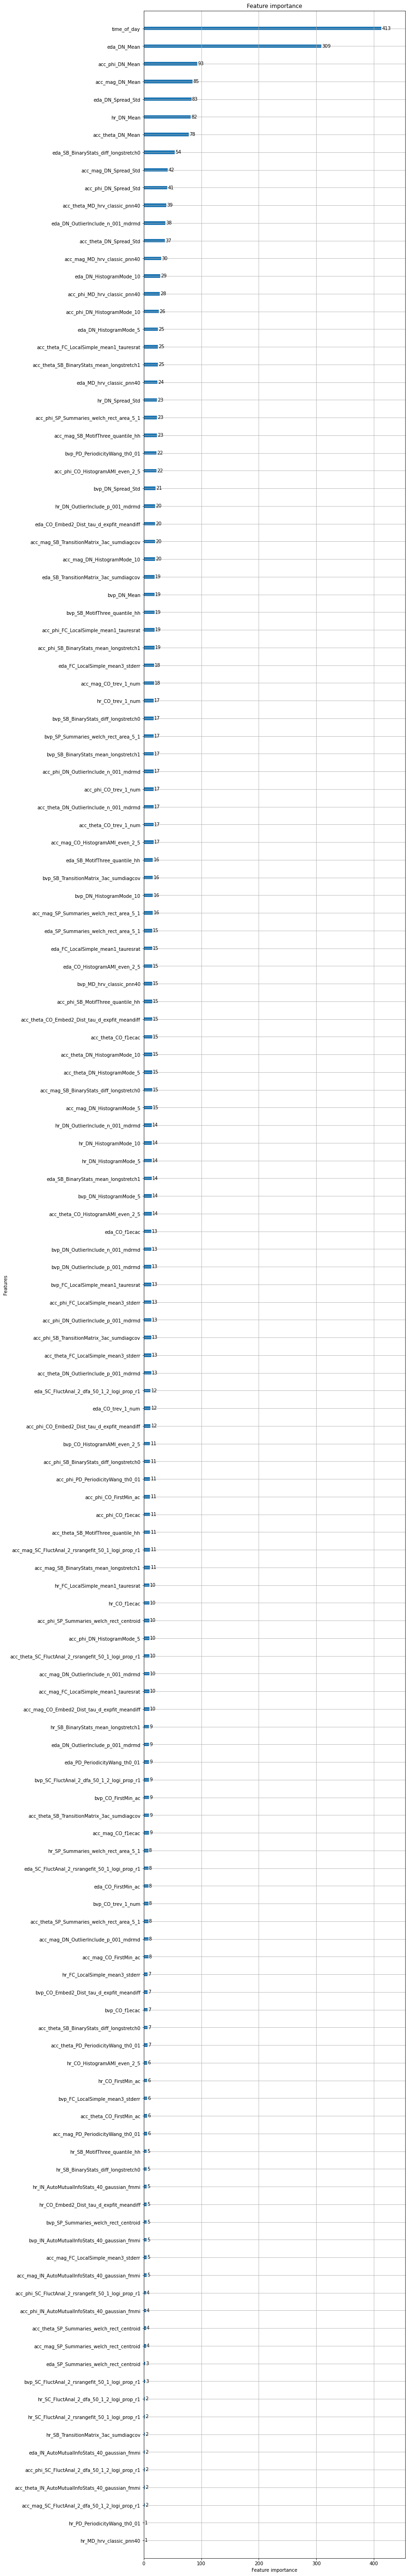

In [8]:
lgb.plot_importance(lgbm, max_num_features=300,figsize=(10,100)) 

In [9]:
# compute importances
importance_df = (
    pd.DataFrame({
        'feature_name': lgbm.feature_name_,
        'importance': lgbm.feature_importances_,
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

                                         feature_name  importance
0                                         time_of_day         413
1                                         eda_DN_Mean         309
2                                     acc_phi_DN_Mean          93
3                                     acc_mag_DN_Mean          85
4                                   eda_DN_Spread_Std          83
..                                                ...         ...
140    acc_phi_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1           2
141                      hr_PD_PeriodicityWang_th0_01           1
142                           hr_MD_hrv_classic_pnn40           1
143               hr_SP_Summaries_welch_rect_centroid           0
144  acc_theta_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1           0

[145 rows x 2 columns]


In [78]:
importance_df['feature_name'][0:15]

0                              time_of_day
1                              eda_DN_Mean
2                          acc_phi_DN_Mean
3                          acc_mag_DN_Mean
4                        eda_DN_Spread_Std
5                               hr_DN_Mean
6                        acc_theta_DN_Mean
7     eda_SB_BinaryStats_diff_longstretch0
8                    acc_mag_DN_Spread_Std
9                    acc_phi_DN_Spread_Std
10          acc_theta_MD_hrv_classic_pnn40
11       eda_DN_OutlierInclude_n_001_mdrmd
12                 acc_theta_DN_Spread_Std
13            acc_mag_MD_hrv_classic_pnn40
14                 eda_DN_HistogramMode_10
Name: feature_name, dtype: object

# Train Model, but Specify Feature Set

In [10]:
# Need to use Light-GBM for more easily available metrics
# Also more sophisticated. 

# Split the dataset into training and testing sets

# Specify Columns to Use as Input (in addition to the time-stamp)
col_names = importance_df['feature_name'][0:100]

# Get time-of-day from timestamp
df['time_of_day']= [i.hour  + i.minute/60 for i in df['utc_timestamp']]

# Perform train-test split. Just Split it across time 3:1
# And need to drop time-stamp. As datetime64 is unsupported 
training_data = df[col_names].iloc[0:int(df.shape[0]*0.75),:]
testing_data = df[col_names].iloc[int(df.shape[0]*0.75):,:]
training_target = df['label'].iloc[0:int(df.shape[0]*0.75)]
testing_target = df['label'].iloc[int(df.shape[0]*0.75):]

# create the LightGBM dataset
train_data = lgb.Dataset(training_data, label=training_target)

# set the parameters for the LightGBM model
# params = {
#     "objective": "binary",
#     #"num_class": 2,
#     "metric": "AUC",
#     "num_leaves": 31,
#     "learning_rate": 0.1,
#     "feature_fraction": 0.9,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "verbose": -1,
# }

# Declare it's a Classifier
lgbm = lgb.LGBMClassifier(is_unbalance=True) # metric="AUC",
# scale_pos_weight = df['label'].value_counts()[0]/df['label'].value_counts()[1]/2)
#  

# train the LightGBM model
lgbm.fit(training_data, training_target )

# Score the classifier on the testing data
y_pred = lgbm.predict(testing_data)

# Save the model
dump(lgbm, 'Fast_automl_acc.joblib')

['Fast_automl_acc.joblib']

In [11]:
print("Accuracy: ", metrics.accuracy_score(testing_target, y_pred))
print(metrics.roc_curve(testing_target,y_pred))
print("AUC (test):", metrics.roc_auc_score(testing_target,y_pred))
print("AUC (train):", metrics.roc_auc_score(training_target,lgbm.predict(training_data)))
print(metrics.confusion_matrix(testing_target,y_pred))

Accuracy:  0.846089255170269
(array([0.        , 0.15184395, 1.        ]), array([0.        , 0.26176471, 1.        ]), array([2, 1, 0]))
AUC (test): 0.5549603763481986
AUC (train): 0.9051651836572068
[[244587  43788]
 [   753    267]]


# Checking a model trained on the cluster

In [3]:
# Load model
with open('Ignore/Output/Faster_automl_acc.pkl','rb') as file:
    clf = pickle.load(file) 

# Load data
data = pd.read_pickle("Ignore/Output/Patient_1110.pkl")

# Specify Colummns that were used as Input (in addition to the time-stamp)
cols = ["acc_mag","acc_theta","acc_phi",]

feature_names = np.loadtxt("Catch22_Featurenames",dtype=str)
col_names = [i + "_" + j for i in cols for j in feature_names]
col_names = col_names + ['time_of_day'] # Add the quality measurements later.

# Get time-of-day from timestamp
df['time_of_day'] = df['utc_timestamp'][0].hour + df['utc_timestamp'][0].minute/60 

# Perform train-test split. Just Split it across time 3:1
# And need to drop time-stamp. As datetime64 is unsupported 
training_data = df[col_names].iloc[0:int(df.shape[0]*0.75),:]
testing_data = df[col_names].iloc[int(df.shape[0]*0.75):,:]
training_target = df['label'].iloc[0:int(df.shape[0]*0.75)]
testing_target = df['label'].iloc[int(df.shape[0]*0.75):]

TypeError: _unpickle_timestamp() takes exactly 3 positional arguments (4 given)

In [4]:
clf

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=102400000, n_jobs=-1, per_run_time_limit=30,
                      time_left_for_this_task=180)

In [7]:
clf

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=102400000, n_jobs=-1, per_run_time_limit=30,
                      time_left_for_this_task=180)

In [8]:
import pickle

In [15]:
with open('Ignore/Output/Faster_automl_acc.pkl','rb') as file:
    clf = pickle.load(file) 

TypeError: _unpickle_timestamp() takes exactly 3 positional arguments (4 given)

In [10]:
# pickle.dump(clf, open('model.pkl', 'wb'))

In [14]:
clf

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=102400000, n_jobs=-1, per_run_time_limit=30,
                      time_left_for_this_task=180)

In [6]:
df['time_of_day']

0          23.166667
1          23.166667
2          23.166667
3          23.166667
4          23.166667
             ...    
1237855    23.166667
1237856    23.166667
1237857    23.166667
1237858    23.166667
1237859    23.166667
Name: time_of_day, Length: 1237860, dtype: float64

# Code to change the labels and remove data points

In [196]:
# Load the new_labels
new_labels = pd.read_csv('/Users/pokhims/Documents/Coding/PK_EForecasting/new_train_labels.csv')

In [197]:
df["utc_timestamp"]

0         2019-12-19 20:20:00+00:00
1         2019-12-19 20:20:10+00:00
2         2019-12-19 20:20:20+00:00
3         2019-12-19 20:20:30+00:00
4         2019-12-19 20:20:40+00:00
                     ...           
1157575   2020-05-11 20:59:10+00:00
1157576   2020-05-11 20:59:20+00:00
1157577   2020-05-11 20:59:30+00:00
1157578   2020-05-11 20:59:40+00:00
1157579   2020-05-11 20:59:50+00:00
Name: utc_timestamp, Length: 1157580, dtype: datetime64[ns, UTC]

In [198]:
new_labels["filepath"]

0         1110/000/UTC-2020_02_26-23_10_00.parquet
1         1110/001/UTC-2020_02_27-17_30_00.parquet
2         1110/001/UTC-2020_02_27-17_40_00.parquet
3         1110/002/UTC-2020_02_27-17_50_00.parquet
4         1110/002/UTC-2020_02_27-18_00_00.parquet
                            ...                   
129824    2002/102/UTC-2021_03_12-03_30_00.parquet
129825    2002/102/UTC-2021_03_12-03_40_00.parquet
129826    2002/102/UTC-2021_03_12-03_50_00.parquet
129827    2002/102/UTC-2021_03_12-04_00_00.parquet
129828    2002/102/UTC-2021_03_12-04_10_00.parquet
Name: filepath, Length: 129829, dtype: object

In [199]:
"UTC-2020_02_26-23_10_00"

'UTC-2020_02_26-23_10_00'

In [200]:
list = []
list2 = []
patient_id = 1876

for i in np.arange(new_labels.shape[0]):
    x = re.search("(\d{4})/.*/UTC-(\d{4})_(\d{2})_(\d{2})-(\d{2})_(\d{2})_(\d{2})",new_labels["filepath"][i])
    if x.group(1) == str(patient_id):
        y = pd.to_datetime(x.group(2)+'-'+x.group(3)+'-'+x.group(4) + ' ' + x.group(5)+':'+x.group(6)+':'+x.group(7) , format='%Y-%m-%d %H:%M:%S',utc=True)
        list.append(y)
        list2.append(new_labels["label"][i])

patient_labels = pd.DataFrame({'utc_timestamp':list,'label':list2})

In [201]:
patient_labels

,utc_timestamp,label
0,2019-12-19 20:20:00+00:00,0
1,2019-12-19 20:30:00+00:00,0
2,2019-12-19 20:40:00+00:00,0
3,2019-12-19 20:50:00+00:00,0
4,2019-12-19 21:00:00+00:00,0
...,...,...
19288,2020-05-11 20:10:00+00:00,0
19289,2020-05-11 20:20:00+00:00,0
19290,2020-05-11 20:30:00+00:00,0
19291,2020-05-11 20:40:00+00:00,0


In [202]:
pd.to_datetime(x.group(1)+'-'+x.group(2)+'-'+x.group(3) + ' ' + x.group(4)+':'+x.group(5)+':'+x.group(6) , format='%Y-%m-%d %H:%M:%S')

ValueError: time data 2002-2021-03 12:04:10 doesn't match format specified

In [203]:
# I'm a dumbass, can just past a format argument to pd.to_datetime

pd.to_datetime("UTC-2020_02_26-23_10_00", format = 'UTC-%Y_%m_%d-%H_%M_%S')

# But this would've been annoying anyways, as I need to drop the first and last parts of the string

Timestamp('2020-02-26 23:10:00')

In [204]:
time_stamp = df['utc_timestamp'][i].floor('10T', ambiguous=False)
print(time_stamp)

2020-01-06 12:10:00+00:00


In [205]:
patient_labels[patient_labels['utc_timestamp']==time_stamp]['label']

2163    0
Name: label, dtype: int64

In [206]:
df.at[0,'label'] = 0

In [207]:
# Now replace labels in df according to the timestamp in new_labels

# Slow code but only needs to be run as a one-off
for i in np.arange(df.shape[0]):
    # Get the Floored UTC timestamp in the featureset
    time_stamp = df['utc_timestamp'][i].floor('10 min')

    # Compare to feature set in patient_labels
    new_label = patient_labels[patient_labels['utc_timestamp']==time_stamp]['label']

    # Replace labels with new labels  - This replaces the actual data in the df. 
    df.at[i,'label'] = new_label


In [208]:
#Check
df['label'].value_counts()

0    1119180
2      30900
1       7500
Name: label, dtype: int64

In [193]:
# Don't drop here
# df = df.drop(df[df['label']==2].index)

In [194]:
df['label'].value_counts()

0    1119180
1       7500
Name: label, dtype: int64

In [210]:
# Train the model again and see what we get

# Need to use Light-GBM for more easily available metrics
# Also more sophisticated. 

# Split the dataset into training and testing sets

# Specify Columns to Use as Input (in addition to the time-stamp)
col_names = importance_df['feature_name'][0:100]

# Get time-of-day from timestamp
df['time_of_day']= [i.hour  + i.minute/60 for i in df['utc_timestamp']]

# Perform train-test split. Just Split it across time 3:1
# And need to drop time-stamp. As datetime64 is unsupported 
# And drop the 2's in the training set
train = df.iloc[0:int(df.shape[0]*0.75),:]
train = train.drop(train[train['label']==2].index)
training_data = train[col_names]
training_target = train['label']
# training_data = df[col_names].iloc[0:int(df.shape[0]*0.75),:]
# training_target = df['label'].iloc[0:int(df.shape[0]*0.75)]

testing_data = df[col_names].iloc[int(df.shape[0]*0.75):,:]
testing_target = df['label'].iloc[int(df.shape[0]*0.75):]

# create the LightGBM dataset
train_data = lgb.Dataset(training_data, label=training_target)

# Declare it's a Classifier
lgbm = lgb.LGBMClassifier(is_unbalance=True) # metric="AUC",
# scale_pos_weight = df['label'].value_counts()[0]/df['label'].value_counts()[1]/2)
#  

# train the LightGBM model
lgbm.fit(training_data, training_target )

# Score the classifier on the testing data
y_pred = lgbm.predict(testing_data)

# Save the model
dump(lgbm, 'Fast_automl_acc.joblib')

['Fast_automl_acc.joblib']

In [211]:
# Convert all 2's to 0's
#y_pred[y_pred==2] = 0 
testing_target = testing_target.replace(2,0)


In [212]:
print(testing_target.value_counts())
print(pd.DataFrame(y_pred).value_counts())

0    288375
1      1020
Name: label, dtype: int64
0    251879
1     37516
dtype: int64


In [215]:
print("Accuracy: ", metrics.accuracy_score(testing_target, y_pred))
print(metrics.roc_curve(testing_target,y_pred))
print("AUC (test):", metrics.roc_auc_score(testing_target,y_pred))
print("AUC (train):", metrics.roc_auc_score(training_target.replace(2,0),lgbm.predict(training_data)))
print(metrics.confusion_matrix(testing_target,y_pred))

Accuracy:  0.8681456141260215
(array([0.       , 0.1294391, 1.       ]), array([0.        , 0.18529412, 1.        ]), array([2, 1, 0]))
AUC (test): 0.5279275096254367
AUC (train): 0.9220302553806072
[[251048  37327]
 [   831    189]]


Verdict is to use the original data labels as is, as I don't want to tune this anymore.

# Get the data quality metrics going

In [167]:
f_s = 128

# Add Quality Features
#df["acc_quality"] =
data["acc_quality"] = RandFuncs.acc_quality_adj(data, f_s)
#df["bvp_quality"] = RandFuncs.bvp_quality_adj(data, f_s)
#df["eda_quality"] = RandFuncs.eda_quality_adj(data, f_s)

# There is a possibility that these need to be performed on a larger window? 
# This is just giving out NaNs.... There is a bug somewhere.  

In [168]:
data

,utc_timestamp,acc_x,acc_y,acc_z,acc_mag,bvp,eda,hr,temp,acc_quality
0,2020-05-25 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-25 23:20:00.007812864+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-25 23:20:00.015624960+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-25 23:20:00.023437824+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-25 23:20:00.031249920+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
76795,2020-05-25 23:29:59.960937472+00:00,-0.997473,62.996995,6.002834,62.291661,-11.010712,0.0,123.394669,NaN,NaN
76796,2020-05-25 23:29:59.968750336+00:00,-0.997473,62.996995,6.002834,62.291661,-24.282581,0.0,123.421586,NaN,NaN
76797,2020-05-25 23:29:59.976562432+00:00,-0.997473,62.996995,6.002834,62.291661,-32.718963,0.0,123.448503,NaN,NaN
76798,2020-05-25 23:29:59.984375296+00:00,-0.997473,62.996995,6.002834,62.291661,-36.834271,0.0,123.475420,NaN,NaN


In [143]:
data.shape

(76800, 9)

In [134]:
data.shape[0]

76800

In [137]:
RandFuncs.bvp_quality_adj(data, f_s).value_counts()

bvp_quality
1              76800
dtype: int64

In [139]:
RandFuncs.eda_quality_adj(data, f_s).value_counts()

eda_quality
1              76544
0                256
dtype: int64

In [133]:
df['utc_timestamp']

0         2019-12-19 20:20:00+00:00
1         2019-12-19 20:20:10+00:00
2         2019-12-19 20:20:20+00:00
3         2019-12-19 20:20:30+00:00
4         2019-12-19 20:20:40+00:00
                     ...           
1157575   2020-05-11 20:59:10+00:00
1157576   2020-05-11 20:59:20+00:00
1157577   2020-05-11 20:59:30+00:00
1157578   2020-05-11 20:59:40+00:00
1157579   2020-05-11 20:59:50+00:00
Name: utc_timestamp, Length: 1126680, dtype: datetime64[ns, UTC]

In [147]:
data_10s = data.iloc[0:1280,:]
print(data_10s)

                           utc_timestamp  acc_x  acc_y  acc_z  acc_mag  bvp  \
0              2020-05-25 23:20:00+00:00    NaN    NaN    NaN      NaN  NaN   
1    2020-05-25 23:20:00.007812864+00:00    NaN    NaN    NaN      NaN  NaN   
2    2020-05-25 23:20:00.015624960+00:00    NaN    NaN    NaN      NaN  NaN   
3    2020-05-25 23:20:00.023437824+00:00    NaN    NaN    NaN      NaN  NaN   
4    2020-05-25 23:20:00.031249920+00:00    NaN    NaN    NaN      NaN  NaN   
...                                  ...    ...    ...    ...      ...  ...   
1275 2020-05-25 23:20:09.960937472+00:00    NaN    NaN    NaN      NaN  NaN   
1276 2020-05-25 23:20:09.968750336+00:00    NaN    NaN    NaN      NaN  NaN   
1277 2020-05-25 23:20:09.976562432+00:00    NaN    NaN    NaN      NaN  NaN   
1278 2020-05-25 23:20:09.984375296+00:00    NaN    NaN    NaN      NaN  NaN   
1279 2020-05-25 23:20:09.992187392+00:00    NaN    NaN    NaN      NaN  NaN   

      eda  hr  temp  
0     NaN NaN   NaN  
1     N

In [154]:
RandFuncs.bvp_quality_adj(data.iloc[0:1280*6,:], f_s).value_counts()

bvp_quality
1              7680
dtype: int64

In [166]:
RandFuncs.acc_quality_adj(data.iloc[0:1280*6,:], f_s).value_counts()

Series([], dtype: int64)

In [163]:
RandFuncs.eda_quality_adj(data.iloc[0:1280*1,:], f_s).value_counts()

eda_quality
1              1280
dtype: int64

# Now time to do hyperparameter tuning

In [246]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback

In [259]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        # "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1010, step=50),
        # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float(
        #     "bagging_fraction", 0.2, 0.95, step=0.1
        # ),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float(
        #     "feature_fraction", 0.2, 0.95, step=0.1
        #),
    }

    # Use KFold with no Shuffling and Stratification so it preserves the time-series
    cv = KFold(n_splits=5, shuffle=False, random_state=None)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", is_unbalance=True, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [235]:
# Import the whole dataset from pkl file
df = pd.read_pickle(os.getcwd()+ "/Ignore/Output/Patient_1876.pkl")
# Specify Columns to Use as Input (in addition to the time-stamp)
# cols = ["acc_mag","acc_theta","acc_phi",]

# feature_names = np.loadtxt("Catch22_Featurenames",dtype=str)
# col_names = [i + "_" + j for i in cols for j in feature_names]
# col_names = col_names + ['time_of_day'] # Add the quality measurements later.

# Get time-of-day from timestamp
df['time_of_day'] = df['utc_timestamp'][0].hour + df['utc_timestamp'][0].minute/60 
col_names = importance_df['feature_name'][0:100]

In [261]:
study.best_params

{'learning_rate': 0.011477317041510369,
 'num_leaves': 180,
 'max_depth': 5,
 'min_data_in_leaf': 310}

In [255]:
preds

array([[0.98191765, 0.01808235],
       [0.98191765, 0.01808235],
       [0.98191765, 0.01808235],
       ...,
       [0.99308844, 0.00691156],
       [0.99308844, 0.00691156],
       [0.99308844, 0.00691156]])

In [265]:
# Use KFold with no Shuffling and Stratification so it preserves the time-series
cv = KFold(n_splits=5, shuffle=False, random_state=None)

cv_scores = np.empty(5)
for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = lgb.LGBMClassifier(objective="binary", is_unbalance=True, **study.best_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="roc_auc_score",
        early_stopping_rounds=100,
    )
    preds = model.predict(X_test)
    cv_scores[idx] = metrics.roc_auc_score(y_test, preds)

/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[1]	valid_0's binary_logloss: 0.0344988
[2]	valid_0's binary_logloss: 0.0383282
[3]	valid_0's binary_logloss: 0.0421598
[4]	valid_0's binary_logloss: 0.0461245
[5]	valid_0's binary_logloss: 0.0502138
[6]	valid_0's binary_logloss: 0.0542004
[7]	valid_0's binary_logloss: 0.0581345
[8]	valid_0's binary_logloss: 0.062071
[9]	valid_0's binary_logloss: 0.0660437
[10]	valid_0's binary_logloss: 0.0699324
[11]	valid_0's binary_logloss: 0.0738941
[12]	valid_0's binary_logloss: 0.07769
[13]	valid_0's binary_logloss: 0.0815099
[14]	valid_0's binary_logloss: 0.0853898
[15]	valid_0's binary_logloss: 0.0892117
[16]	valid_0's binary_logloss: 0.0930733
[17]	valid_0's binary_logloss: 0.0969189
[18]	valid_0's binary_logloss: 0.100752
[19]	valid_0's binary_logloss: 0.104398
[20]	valid_0's binary_logloss: 0.108157
[21]	valid_0's binary_logloss: 0.111872
[22]	valid_0's binary_logloss: 

/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[1]	valid_0's binary_logloss: 0.0521108
[2]	valid_0's binary_logloss: 0.0538242
[3]	valid_0's binary_logloss: 0.0561031
[4]	valid_0's binary_logloss: 0.0587378
[5]	valid_0's binary_logloss: 0.0616227
[6]	valid_0's binary_logloss: 0.0645782
[7]	valid_0's binary_logloss: 0.0676613
[8]	valid_0's binary_logloss: 0.0707889
[9]	valid_0's binary_logloss: 0.0739214
[10]	valid_0's binary_logloss: 0.0771114
[11]	valid_0's binary_logloss: 0.0803563
[12]	valid_0's binary_logloss: 0.0835771
[13]	valid_0's binary_logloss: 0.0868519
[14]	valid_0's binary_logloss: 0.0901597
[15]	valid_0's binary_logloss: 0.0934154
[16]	valid_0's binary_logloss: 0.0966516
[17]	valid_0's binary_logloss: 0.0999469
[18]	valid_0's binary_logloss: 0.10326
[19]	valid_0's binary_logloss: 0.106455
[20]	valid_0's binary_logloss: 0.109707
[21]	valid_0's binary_logloss: 0.112879
[22]	valid_0's binary_logloss

/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[1]	valid_0's binary_logloss: 0.0463508
[2]	valid_0's binary_logloss: 0.0487999
[3]	valid_0's binary_logloss: 0.0517078
[4]	valid_0's binary_logloss: 0.0547722
[5]	valid_0's binary_logloss: 0.0579963
[6]	valid_0's binary_logloss: 0.0613776
[7]	valid_0's binary_logloss: 0.0647156
[8]	valid_0's binary_logloss: 0.0681744
[9]	valid_0's binary_logloss: 0.0716095
[10]	valid_0's binary_logloss: 0.0751
[11]	valid_0's binary_logloss: 0.0785239
[12]	valid_0's binary_logloss: 0.0819876
[13]	valid_0's binary_logloss: 0.0852176
[14]	valid_0's binary_logloss: 0.0886094
[15]	valid_0's binary_logloss: 0.0920498
[16]	valid_0's binary_logloss: 0.0954945
[17]	valid_0's binary_logloss: 0.0989015
[18]	valid_0's binary_logloss: 0.102247
[19]	valid_0's binary_logloss: 0.105523
[20]	valid_0's binary_logloss: 0.108972
[21]	valid_0's binary_logloss: 0.112285
[22]	valid_0's binary_logloss: 

/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[1]	valid_0's binary_logloss: 0.0394255
[2]	valid_0's binary_logloss: 0.042291
[3]	valid_0's binary_logloss: 0.0454538
[4]	valid_0's binary_logloss: 0.0487447
[5]	valid_0's binary_logloss: 0.0521598
[6]	valid_0's binary_logloss: 0.0556271
[7]	valid_0's binary_logloss: 0.0591309
[8]	valid_0's binary_logloss: 0.0626695
[9]	valid_0's binary_logloss: 0.0661542
[10]	valid_0's binary_logloss: 0.0696112
[11]	valid_0's binary_logloss: 0.073196
[12]	valid_0's binary_logloss: 0.0766251
[13]	valid_0's binary_logloss: 0.0800656
[14]	valid_0's binary_logloss: 0.0835312
[15]	valid_0's binary_logloss: 0.0870199
[16]	valid_0's binary_logloss: 0.0905002
[17]	valid_0's binary_logloss: 0.093889
[18]	valid_0's binary_logloss: 0.0973772
[19]	valid_0's binary_logloss: 0.100678
[20]	valid_0's binary_logloss: 0.103977
[21]	valid_0's binary_logloss: 0.107409
[22]	valid_0's binary_logloss:

/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[1]	valid_0's binary_logloss: 0.0325102
[2]	valid_0's binary_logloss: 0.0361135
[3]	valid_0's binary_logloss: 0.0398688
[4]	valid_0's binary_logloss: 0.0436577
[5]	valid_0's binary_logloss: 0.0474614
[6]	valid_0's binary_logloss: 0.0512716
[7]	valid_0's binary_logloss: 0.0550553
[8]	valid_0's binary_logloss: 0.058897
[9]	valid_0's binary_logloss: 0.0626752
[10]	valid_0's binary_logloss: 0.066511
[11]	valid_0's binary_logloss: 0.0703286
[12]	valid_0's binary_logloss: 0.0740177
[13]	valid_0's binary_logloss: 0.0777404
[14]	valid_0's binary_logloss: 0.0814466
[15]	valid_0's binary_logloss: 0.0851914
[16]	valid_0's binary_logloss: 0.0887733
[17]	valid_0's binary_logloss: 0.0924777
[18]	valid_0's binary_logloss: 0.0960886
[19]	valid_0's binary_logloss: 0.099714
[20]	valid_0's binary_logloss: 0.103267
[21]	valid_0's binary_logloss: 0.106901
[22]	valid_0's binary_logloss

In [266]:
cv_scores

array([0.5, 0.5, 0.5, 0.5, 0.5])

In [263]:
# preds = model.predict(X_test)
# cv_scores[idx] = metrics.roc_auc_score(y_test, preds)

# Declare it's a Classifier
lgbm = lgb.LGBMClassifier(objective="binary", is_unbalance=True, **study.best_params)

# train the LightGBM model
lgbm.fit(training_data, training_target )

# Score the classifier on the testing data
y_pred = lgbm.predict(testing_data)

print("Accuracy: ", metrics.accuracy_score(testing_target, y_pred))
print(metrics.roc_curve(testing_target,y_pred))
print("AUC (test):", metrics.roc_auc_score(testing_target,y_pred))
print("AUC (train):", metrics.roc_auc_score(training_target,lgbm.predict(training_data)))
print(metrics.confusion_matrix(testing_target,y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
Accuracy:  0.9130980148240294
(array([0.        , 0.08376593, 1.        ]), array([0.        , 0.02647059, 1.        ]), array([2, 1, 0]))
AUC (test): 0.47135232922818016
AUC (train): 0.8231315271746129
[[264219  24156]
 [   993     27]]


In [264]:
# compute importances
importance_df = (
    pd.DataFrame({
        'feature_name': lgbm.feature_name_,
        'importance': lgbm.feature_importances_,
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
print(importance_df)

                                feature_name  importance
0                                time_of_day         866
1                                eda_DN_Mean         484
2                            acc_mag_DN_Mean         197
3                          acc_theta_DN_Mean         193
4       eda_SB_BinaryStats_diff_longstretch0         150
..                                       ...         ...
95                       acc_theta_CO_f1ecac           0
96              acc_theta_DN_HistogramMode_5           0
97  acc_mag_SB_BinaryStats_diff_longstretch0           0
98      eda_SP_Summaries_welch_rect_area_5_1           0
99    bvp_SB_TransitionMatrix_3ac_sumdiagcov           0

[100 rows x 2 columns]


In [258]:
cv_scores

array([0.5, 0.5, 0.5, 0.5, 0.5])

In [260]:
X = df[col_names]
y = df['label'] 


study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2023-02-27 16:41:24,982] A new study created in memory with name: LGBM Classifier
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=960


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=960


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=960


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=960


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=960


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=510, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=510


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=710


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1010


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1010


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1010


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1010


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1010


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=560, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=560


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


[I 2023-02-27 16:56:27,593] Trial 7 pruned. Trial was pruned at iteration 1.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=860


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2023-02-27 16:59:31,411] Trial 10 pruned. Trial was pruned at iteration 1.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


[I 2023-02-27 17:01:07,985] Trial 12 pruned. Trial was pruned at iteration 1.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=410, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=410


[I 2023-02-27 17:03:04,798] Trial 14 pruned. Trial was pruned at iteration 0.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-27 17:03:11,506] Trial 15 pruned. Trial was pruned at iteration 0.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_sto

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160


/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/Users/pokhims/neuro/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The 

[LightGBM] [Warning] min_data_in_leaf is set=360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=360


[I 2023-02-27 17:05:16,931] Trial 17 pruned. Trial was pruned at iteration 0.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-27 17:05:23,022] Trial 18 pruned. Trial was pruned at iteration 0.
/Users/pokhims/neuro/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-27 17:05:30,289] Trial 19 pruned. Trial was pruned at iteration 0.
